In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
# Read the data
raw_dataset = pd.read_csv("../DATA/league_games.csv")

# Alterando o conjunto de dados
Como observado no notebook `initial-analysis.ipynb` o modelo _baseline_ apresentou taxa de acerto acima de 98%. Esse resultado sugere que a seleção das features (comparar os dados entre as equipes) não foi boa. Nesse sentido, decidimos remodelar o problema.

O novo problema será _com base nos dados relacionados à equipe azul, vamos tentar prever o outcome da partida, ou seja, se a equipe azul ganhou ou não_. Com isso em mente, precisamos remover algumas features do conjunto anterior.

In [5]:
# Print all columns name
display(raw_dataset.columns)

Index(['blue.win', 'blue.firstBlood', 'blue.firstTower', 'blue.firstInhibitor',
       'blue.firstBaron', 'blue.firstDragon', 'blue.firstRiftHerald',
       'blue.towerKills', 'blue.inhibitorKills', 'blue.baronKills',
       'blue.dragonKills', 'blue.riftHeraldKills', 'red.win', 'red.firstBlood',
       'red.firstTower', 'red.firstInhibitor', 'red.firstBaron',
       'red.firstDragon', 'red.firstRiftHerald', 'red.towerKills',
       'red.inhibitorKills', 'red.baronKills', 'red.dragonKills',
       'red.riftHeraldKills', 'blue.kills', 'red.kills', 'blue.deaths',
       'red.deaths', 'blue.assists', 'red.assists', 'blue.visionScore',
       'red.visionScore', 'blue.csPerMin', 'red.csPerMin', 'blue.goldPerMin',
       'red.goldPerMin', 'blue.crowdControlTime', 'red.crowdControlTime'],
      dtype='object')

In [6]:
# Create a new dataset without red team information
to_drop = [
    'red.win', 'red.firstBlood', 'red.firstTower', 'red.firstInhibitor',
    'red.firstBaron', 'red.firstDragon', 'red.firstRiftHerald', 'red.towerKills',
    'red.inhibitorKills', 'red.baronKills', 'red.dragonKills', 'red.riftHeraldKills',
    'red.kills', 'red.deaths', 'red.assists', 'red.visionScore', 'red.csPerMin',
    'red.goldPerMin', 'red.crowdControlTime'
]

blue_dataset = raw_dataset.copy()
blue_dataset.drop(to_drop, axis=1, inplace=True)

display(blue_dataset.columns)

Index(['blue.win', 'blue.firstBlood', 'blue.firstTower', 'blue.firstInhibitor',
       'blue.firstBaron', 'blue.firstDragon', 'blue.firstRiftHerald',
       'blue.towerKills', 'blue.inhibitorKills', 'blue.baronKills',
       'blue.dragonKills', 'blue.riftHeraldKills', 'blue.kills', 'blue.deaths',
       'blue.assists', 'blue.visionScore', 'blue.csPerMin', 'blue.goldPerMin',
       'blue.crowdControlTime'],
      dtype='object')

In [7]:
# Print more informations
display(blue_dataset.dtypes, blue_dataset.shape)

blue.win                   int64
blue.firstBlood            int64
blue.firstTower            int64
blue.firstInhibitor        int64
blue.firstBaron            int64
blue.firstDragon           int64
blue.firstRiftHerald       int64
blue.towerKills            int64
blue.inhibitorKills        int64
blue.baronKills            int64
blue.dragonKills           int64
blue.riftHeraldKills       int64
blue.kills                 int64
blue.deaths                int64
blue.assists               int64
blue.visionScore           int64
blue.csPerMin            float64
blue.goldPerMin          float64
blue.crowdControlTime      int64
dtype: object

(16272, 19)

# Split do conjunto de dados: treino e teste
Inicialmente iremos separar o conjunto `blue_dataset` em dois subconjuntos: treinamento e teste. Esse tipo de procedimento é importante para evitar fenômenos como _overfitting_. Usando a biblioteca scikit-learn podemos separar aleatoriamente o conjunto principal a partir da função auxiliar `train_test_split`. A separação será feita usando a relação 80/20, ou seja, 80% dos dados serão de treinamento e os 20% restantes serão de teste.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_80_20(df):
    """
    Split Dataframe df into random train and test subsets. Using 80/20
    division.

    Parameters
    ----------
    df : DataFrame
        Dataset to be splitted.
    
    Returns
    -------
    X_train : DataFrame
        Training dataset.
    X_test : DataFrame
        Testing dataset.
    y_train : Series
        Training targets.
    y_test : Series
        Testing targets.
    """
    # Split dataset into features and target.
    target_name = "blue.win"
    target = df[target_name]
    features = df.drop(target_name, 1)

    # Split into train and test subsets.
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = split_80_20(blue_dataset)
print("==> Training subset:", end="")
display(X_train.shape, y_train.shape)
print("==> Testing subset:", end="")
display(X_test.shape, y_test.shape)

==> Training subset:

(13017, 18)

(13017,)

==> Testing subset:

(3255, 18)

(3255,)

# Definindo a baseline
O modelo _baseline_ servirá como um "guia" para mensurar a qualidade dos modelos mais sofisticados. A _baseline_, nesse caso, poderá nos informar sobre possíveis complexidades desnecessárias. A baseline escolhida será o **Perceptron**. A biblioteca scikit-learn (ou *sklearn*) implementa este classificador por meio dos modelos lineares (`linear_model.Perceptron`). Como a ideia é manter o modelo simples, os parâmetros escolhidos para o modelo serão os *defaults*.
- Número de épocas (`max_iter`): 1000;
- Critério de parada (`tol`): 1e-3;
Além do que foi mencionado acima, será escolhido um subconjunto das features para realizar a classificação. Dessa forma, selecionando aquelas mais intuitivas, o modelo inicial será mais conciso.

## Matriz de correlação

In [11]:
def corr_heatmap(df, digits=2, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Parameters
    ----------
    df : DataFrame
        Dataset to check correlation heatmap.
        
    digits : int
        Number of decimal places to display
    
    cmap : str
        Colormap to display correlation range. Preferably divergent colormap
        see https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging.
        df (DataFrame) : DataFrame with features to check multicollinearity on.

    Returns
    -------
    fig : Matplotlib Figure
    
    ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    correl

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    
    plt.show()

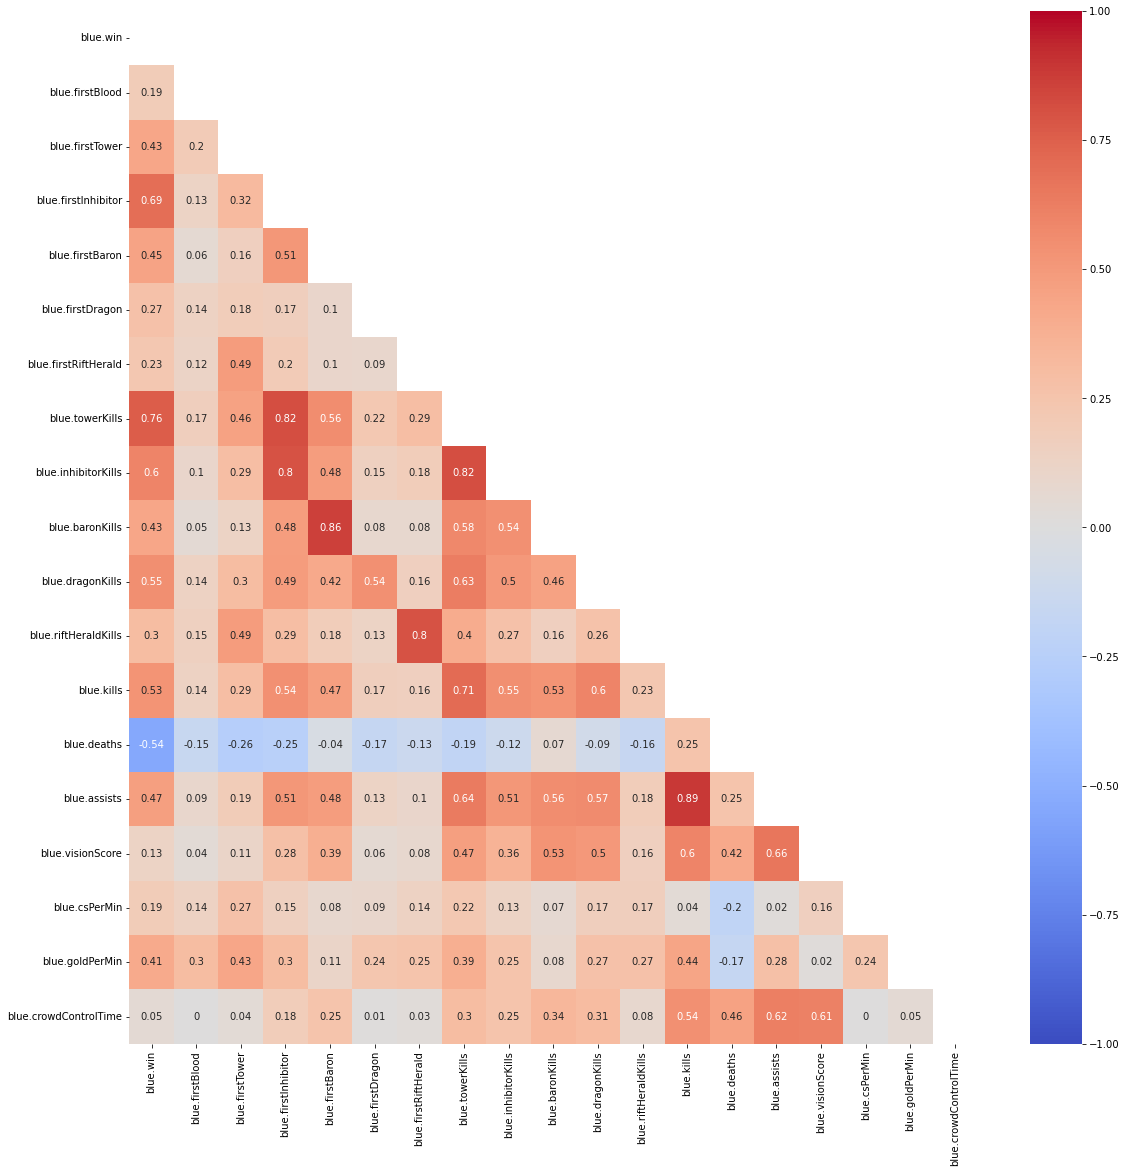

In [12]:
corr_heatmap(blue_dataset)

Em geral, as features apresentam baixo grau de correlação. A maioria está entre -.5 e .5, ilustrando baixa correlação.

Features com correlação para ficar de olho:
- `blue.firstInhibitor` com `blue.(tower & inhibitor)Kills`;
- `blue.firstBaron` com `blue.baronKills`;
- `blue.assists` com `blue.kills`.

## Perceptron

In [13]:
from sklearn.linear_model import Perceptron
def _baseline():
    """
    Baseline: Linear perceptron classifier model.

    Returns
    -------
    baseline : classifier object
        Baseline it self.
    """
    clf = Perceptron(random_state=42) # fixed seed for reproductibility
    return clf    

In [14]:
from sklearn.metrics import classification_report, plot_confusion_matrix
def _eval_model(
        model, X_train, X_test, y_train, y_test,
        params=False, digits_fmt=4):
    """
    Displays evaluation metrics including classification report and
    confusion matrix.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    This function is associated with `fit_and_evaluate()`. More 
    information see its description.

    Parameters
    ----------
    digits_fmt : int
        Number of digits for formatting output floating point values.
    """
    # Get predictions.
    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)

    # Classification report
    print("=== CLASSIFICATION REPORT - TRAINING DATA ===")
    print(classification_report(y_train, y_predict_train, digits=digits_fmt))

    print("=== CLASSIFICATION REPORT - TESTING DATA ===")
    print(classification_report(y_test, y_predict_test, digits=digits_fmt))

    print("=== CONFUSION MATRIX ===")
    fig, ax = plt.subplots(figsize=(5,5))
    plot_confusion_matrix(
        model, X_test, y_test,
        normalize="true",
        cmap="Purples",
        ax=ax)
    ax.set_title("Confusion Matrix")
    plt.show()

    if params:
        print("=== MODEL PARAMETERS ===")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns["parameters"]
        display(params)

def fit_and_evaluate(model, X_train, X_test, y_train, y_test, params=False):
    """
    Fits model on training data and displays classification evaluation metrics.

    Parameters
    ----------
    model : classifier object
        Type of classificatier model to use.
    X_train : DataFrame
        Training data with features variables.
    X_test : DataFrame
        Testing data with features variables.
    y_train : Series
        Training data with target variable.
    y_test : Series
        Testing data with target variable.
    params : bool
        Prints table of hyperparameters used in model.
        
    Returns
    -------
    model : classifier object
        Model after fitting on training data.
    """
    model.fit(X_train, y_train)
    _eval_model(model, X_train, X_test, y_train, y_test, params=params)

    return model

=== CLASSIFICATION REPORT - TRAINING DATA ===
              precision    recall  f1-score   support

           0     0.8581    0.9922    0.9203      6520
           1     0.9907    0.8353    0.9064      6497

    accuracy                         0.9139     13017
   macro avg     0.9244    0.9137    0.9133     13017
weighted avg     0.9243    0.9139    0.9133     13017

=== CLASSIFICATION REPORT - TESTING DATA ===
              precision    recall  f1-score   support

           0     0.8775    0.9867    0.9289      1655
           1     0.9842    0.8575    0.9165      1600

    accuracy                         0.9232      3255
   macro avg     0.9309    0.9221    0.9227      3255
weighted avg     0.9299    0.9232    0.9228      3255

=== CONFUSION MATRIX ===


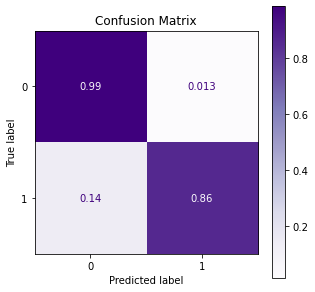

In [79]:
selected_features = ["blue.kills", "blue.deaths"]
baseline = fit_and_evaluate(
    _baseline(), X_train[selected_features], X_test[selected_features], y_train, y_test)

Resultado surpreendente. Nosso _macro recall score_ é 0.9137 (conjunto de treino) e 0.9221 (conjunto de testes). Isso significa que entre as vitórias e derrotas verdadeiras, o modelo Perceptron prediz 92.21% delas corretamente. Também não temos nenhum problema com overfitting nem underfit.

## Fronteira de decisão

In [71]:
def plot_decision_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.15)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, alpha=0.8, edgecolors="k")
    plt.xlabel("blue.kills")
    plt.ylabel("blue.deaths")
    plt.title("Decision boundary for baseline")

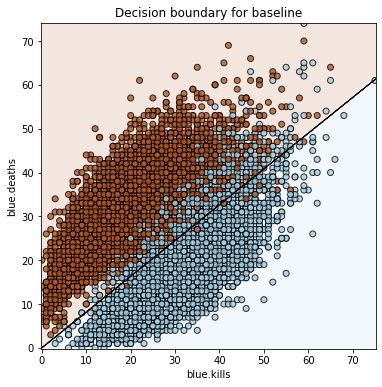

In [72]:
plot_decision_boundary(baseline, X_train[selected_features].to_numpy(), y_train)

# Sofisticando os modelos

## Regressão logística
O primeiro modelo testado será a Regressão Logística. Neste modelo, as probabilidades que descrevem os possíveis resultados de uma única tentativa são modeladas usando uma função logística. A implementação escolhida foi a `LogisticRegression` da biblioteca **scikit-learn**.

A seleção do conjunto de validação será feita utilizando o método de _cross-validation_ (CV) **stratified k-fold** com 10 _splits_ e 4 repetições (no scikit-learn, `RepeatedStratifiedKFold`). Os parâmetros testados para a Regressão Logística serão:
- Com e sem regularização (usando penalidade `l2`);
- Parâmetro de regularização $C$: 0.1, 0.5, 1.0, 10, 100, 1000;

OBS: a força da regularização é inversamente proporcional ao $C$.

In [34]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [35]:
def _define_model1():
    """
    Logistic Regression model with cross-validation and parameter tuning.

    Returns
    -------
    classifier : classifier object
        Logistic Regression model it self.
    """
    parameters = {'penalty': ['none', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
    lr = LogisticRegression(random_state=42)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=42)
    clf = GridSearchCV(lr, parameters, cv=cv)

    return clf

=== CLASSIFICATION REPORT - TRAINING DATA ===
              precision    recall  f1-score   support

           0     0.9780    0.9742    0.9761      6520
           1     0.9742    0.9780    0.9761      6497

    accuracy                         0.9761     13017
   macro avg     0.9761    0.9761    0.9761     13017
weighted avg     0.9761    0.9761    0.9761     13017

=== CLASSIFICATION REPORT - TESTING DATA ===
              precision    recall  f1-score   support

           0     0.9816    0.9668    0.9741      1655
           1     0.9662    0.9812    0.9736      1600

    accuracy                         0.9739      3255
   macro avg     0.9739    0.9740    0.9739      3255
weighted avg     0.9740    0.9739    0.9739      3255

=== CONFUSION MATRIX ===


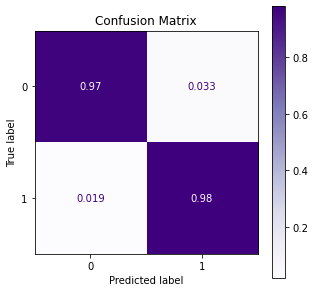

In [36]:
reglog = fit_and_evaluate(
    _define_model1(), X_train, X_test, y_train, y_test)

Neste caso, o macro recall score atingiu 0.9761 (conjunto de treino) e 0.9740 (conjunto de testes). O modelo Logístico conseguiu melhorar a performance em pouco mais de 5%. E os melhores parâmetros foram:

In [37]:
print("=== BEST PARAMETERS ===")
display(reglog.best_params_)

=== BEST PARAMETERS ===


{'C': 100, 'penalty': 'l2'}

## Support Vector Machines
_Support Vector Machines_ ou SVM é um algoritmo que têm por objetivo encontrar o um hiperplano no espaço $N$-dimensional que divide o conjunto de dados, classificando-os. Existem infinitos hiperplanos que podem separar o conjunto de dados. O SVM nesse caso seleciona o melhor hiperplano que maximize a margem, ou seja, a distância entre os pontos do conjunto de dados.

Este método se mostrou mais sofisticado devido a suas vantagens:
- Efetivo em altas dimensões;
- Eficiente em memória por utilizar um subconjunto dos dados de treinamento (os _Support Vectors_);
- Versátil por possibilitar o uso de diferentes _kernels_ como função de decisão, permitindo classificações não-lineares.

A implementação escolhida faz parte da classe `svm` do sklearn, especificamente `svm.LinearSVC`. A implementação escolhida não permite mudança no kernel, mas é considerada mais rápida. A validação será semelhante àquela usada na Regressão Logística -- **stratified k-fold** com 10 _splits_ e 4 repetições. Os parâmetros usados serão:
- Regularização (usando penalidade `l1` e `l2`);
- Parâmetro de regularização $C$: 0.1, 0.5, 1.0, 10, 100, 1000;

In [17]:
from sklearn.svm import LinearSVC

In [18]:
def _define_model2():
    """
    Linear Support Vector Classification with cross-validation and parameter tuning.

    Returns
    -------
    classifier : classifier object
        Linear Support Vector Classifier it self.
    """
    parameters = {'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
    lSVC = LinearSVC(random_state=42)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=42)
    clf = GridSearchCV(lSVC, parameters, cv=cv)

    return clf

=== CLASSIFICATION REPORT - TRAINING DATA ===
              precision    recall  f1-score   support

           0     0.9832    0.9684    0.9757      6520
           1     0.9688    0.9834    0.9760      6497

    accuracy                         0.9759     13017
   macro avg     0.9760    0.9759    0.9759     13017
weighted avg     0.9760    0.9759    0.9759     13017

=== CLASSIFICATION REPORT - TESTING DATA ===
              precision    recall  f1-score   support

           0     0.9864    0.9607    0.9734      1655
           1     0.9604    0.9862    0.9732      1600

    accuracy                         0.9733      3255
   macro avg     0.9734    0.9735    0.9733      3255
weighted avg     0.9736    0.9733    0.9733      3255

=== CONFUSION MATRIX ===


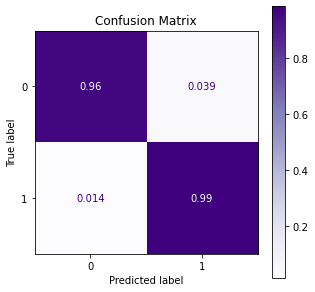

In [19]:
linSVC = fit_and_evaluate(
    _define_model2(), X_train, X_test, y_train, y_test)

Usando SVMs, o macro recall score atingiu 0.9759 (conjunto de treino) e 0.9735 (conjunto de testes). Os resultados foram levemente menores que aqueles obtidos pela Regressão Logística. E os melhores parâmetros obtidos foram:

In [33]:
print("=== BEST PARAMETERS ===")
display(linSVC.best_params_)

=== BEST PARAMETERS ===


{'C': 0.5, 'penalty': 'l2'}

# Interpretando os resultados
Nós podemos extrair os coeficientes das features e sua importância para a vitória da equipe azul. Os coeficientes da Regressão Logística podem ser interpretados, mediante algumas transformações, como o impacto (em porcentagem) de cada feature para a vitória da equipe azul. Assim para cada coeficiente $\theta_i$ ($i$ uma dada feature), temos que o impacto de $i$ é dado por
$$
\exp{\theta_i} - 1
$$

In [39]:
# Extract coefficients from log_grid.best_estimator_ model.
log_coeff = pd.Series(reglog.best_estimator_.coef_.flatten(),
               index=X_train.columns).sort_values(ascending=False)
log_coeff

blue.towerKills          0.918588
blue.inhibitorKills      0.249880
blue.baronKills          0.210460
blue.dragonKills         0.209291
blue.kills               0.207507
blue.firstInhibitor      0.120670
blue.firstDragon         0.093657
blue.firstBaron          0.068558
blue.assists             0.055951
blue.csPerMin            0.027877
blue.firstTower          0.016682
blue.goldPerMin         -0.000334
blue.crowdControlTime   -0.007803
blue.visionScore        -0.020793
blue.firstRiftHerald    -0.032146
blue.firstBlood         -0.044492
blue.riftHeraldKills    -0.116105
blue.deaths             -0.345237
dtype: float64

In [40]:
# Convert log coefficients to odds and subtract 1 to display change in odds.
log_odds = np.exp(log_coeff) - 1
log_odds

blue.towerKills          1.505750
blue.inhibitorKills      0.283872
blue.baronKills          0.234246
blue.dragonKills         0.232803
blue.kills               0.230607
blue.firstInhibitor      0.128252
blue.firstDragon         0.098183
blue.firstBaron          0.070963
blue.assists             0.057546
blue.csPerMin            0.028269
blue.firstTower          0.016822
blue.goldPerMin         -0.000334
blue.crowdControlTime   -0.007773
blue.visionScore        -0.020578
blue.firstRiftHerald    -0.031634
blue.firstBlood         -0.043517
blue.riftHeraldKills    -0.109618
blue.deaths             -0.291947
dtype: float64

In [43]:
# Change name of columns
renamed_cols = {
    "blue.towerKills": "Towers Destroyed",
    "blue.inhibitorKills": "Inhibitors Destroyed",
    "blue.baronKills": "Barons Killed",
    "blue.dragonKills": "Dragons Killed",
    "blue.kills": "Kills",
    "blue.firstInhibitor": "First Inhibitor",
    "blue.firstDragon": "First Dragon",
    "blue.firstBaron": "First Baron",
    "blue.assists": "Assists",
    "blue.csPerMin": "CS per Minute",
    "blue.firstTower": "First Tower",
    "blue.goldPerMin": "Gold per Minute",
    "blue.crowdControlTime": "Crowd Control Time",
    "blue.visionScore": "Vision Score",
    "blue.firstRiftHerald": "First Herald",
    "blue.firstBlood": "First Blood",
    "blue.riftHeraldKills": "Heralds Killed",
    "blue.deaths": "Deaths"
               }

log_odds.rename(renamed_cols, inplace=True)
log_odds

Towers Destroyed        1.505750
Inhibitors Destroyed    0.283872
Barons Killed           0.234246
Dragons Killed          0.232803
Kills                   0.230607
First Inhibitor         0.128252
First Dragon            0.098183
First Baron             0.070963
Assists                 0.057546
CS per Minute           0.028269
First Tower             0.016822
Gold per Minute        -0.000334
Crowd Control Time     -0.007773
Vision Score           -0.020578
First Herald           -0.031634
First Blood            -0.043517
Heralds Killed         -0.109618
Deaths                 -0.291947
dtype: float64

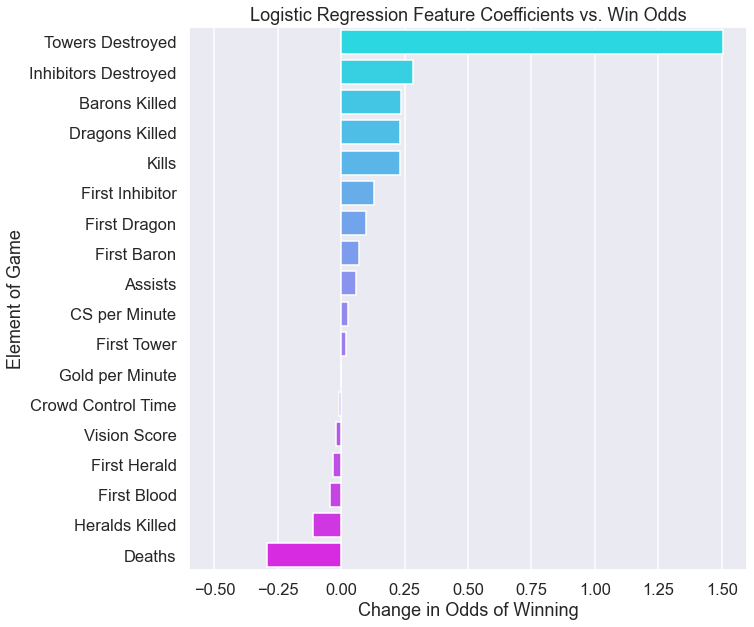

In [44]:
# Set theme and style for plots.
sns.set_theme('talk')
sns.set_style('darkgrid')

# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=log_odds.values, y=log_odds.index, palette='cool', ax=ax, orient='h')

ax.set_title('Logistic Regression Feature Coefficients vs. Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Element of Game')
ax.set_xlim([-.6, 1.6]);

O maior impacto para a vitória do time azul está nas torres destruída (bastante intuitivo), seguido dos inibidores destruídos, Barões abatidos, Dragões abatidos e abates. Podemos observar que fazer esses objetivos primeiro também resultam em um grande impacto para a vitória. Curiosamente, o Arauto, a primeira torre, o tempo de controle de grupo, ouro recebido e tropas abatidas por minuto, não contribuem tanto para a vitória. Além disso, métricas relacionadas ao Arauto resultaram em contribuições negativas para a vitória. Isso pode ser justificado pelo fato de que objetivos maiores como o Barão são mais importantes para finalizar a partida. Por fim, as mortes contribuem negativamente para a vitória da equipe azul o que faz bastante sentido. 